# Alzheption Feature Extraction and Classification

## Packages

In [1]:
import os
import torch
import kornia
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import torchvision as tv
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
from TfELM.Resources.Kernel import Kernel, CombinedProductKernel, CombinedSumKernel
from TfELM.Resources.kernel_distances import calculate_pairwise_distances_vector, calculate_pairwise_distances
from TfELM.Layers.KELMLayer import KELMLayer
from TfELM.Models.KELMModel import KELMModel
from TfELM.Layers.OSELMLayer import OSELMLayer
from TfELM.Models.OSELMModel import OSELMModel

2025-03-02 11:10:45.777719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 11:10:45.954920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740888646.020377  530778 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740888646.038939  530778 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 11:10:46.230343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Definition

### Cross Validation

In [3]:
def custom_cross_val_score(model, X, y, n_splits=10, n_repeats=5, scoring=accuracy_score):
    """
    Custom implementation of cross-validation.

    Parameters:
    -----------
    model : object
        The machine learning model with .fit() and .predict() methods.
    X : np.array or pd.DataFrame
        Feature matrix.
    y : np.array or pd.Series
        Target labels.
    n_splits : int, optional (default=10)
        Number of splits for KFold.
    n_repeats : int, optional (default=5)
        Number of times cross-validation is repeated.
    scoring : function, optional (default=accuracy_score)
        Scoring function to evaluate model performance.

    Returns:
    --------
    list
        List of scores from each fold.
    """
    scores = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    for train_idx, test_idx in rkf.split(X):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        model.fit(X_train, y_train)

        # Predict & convert to NumPy
        y_pred = model.predict(X_test)
        if not isinstance(y_pred, np.ndarray):  # Convert to NumPy if not already
            y_pred = y_pred.numpy()

        # Calculate score
        score = scoring(y_test, y_pred)
        scores.append(score)

    return scores

### CLAHE

In [4]:
class Clahe(torch.nn.Module):
    def __init__(self, clip_limit: int | float = 40, grid_size: tuple[int, int] = (8, 8)) -> None:
        super().__init__()
        self.clip_limit, self.grid_size = float(clip_limit), grid_size

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return kornia.enhance.equalize_clahe(img, self.clip_limit, self.grid_size)

    def __repr__(self) -> str:
        return "{}(clip_limit={}, tile_grid_size={})".format(
            self.__class__.__name__,
            self.clip_limit,
            self.grid_size
        )

### Alzheption Extractor

In [5]:
class AlzheptionExtractor():
    def __init__(
            self,
            path_dataset: str, 
            test_size: float, 
            train_transform: tv.transforms.Compose, 
            test_transform: tv.transforms.Compose,
            batch_size=256,
        ):
        self.path_dataset = path_dataset
        self.test_size = test_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.batch_size = batch_size

        self._dataset: tv.datasets.ImageFolder | None = None
        self._train_indices: torch.utils.data.Subset | None = None
        self._test_indices: torch.utils.data.Subset | None = None
        self._dataset_train: torch.utils.data.Subset | None = None
        self._dataset_test: torch.utils.data.Subset | None = None
        self._train_loader: torch.utils.data.DataLoader | None = None
        self._test_loader: torch.utils.data.DataLoader | None = None
        self._device: torch.device | None = None
        self._model: tv.models.Inception3 | None = None
        self._train_features: np.ndarray | None = None
        self._test_features: np.ndarray | None = None
        self._train_labels: np.ndarray | None = None
        self._test_labels: np.ndarray | None = None

    def __call__(self) -> tuple[np.ndarray, np.ndarray]:
        return self.train_features, self.test_features

    def save_extractor(self, dir_path=".") -> None:
        self._model.to(torch.device("cpu"))

        if os.path.exists(dir_path) is False:
            print(f"Destination path doesn't exists. Creating new dirs: {dir_path}")
            os.makedirs(dir_path)

        with open(f"{dir_path}/AlzheptionExtractor.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load_extractor(cls, filepath="./AlzheptionExtractor.pkl", path_dataset_new: str | None = None) -> "AlzheptionExtractor":
        with open(filepath, "rb") as f:
            obj: AlzheptionExtractor = pickle.load(f)
        
        if not os.path.exists(obj.path_dataset):
            obj._dataset = None
        
        if isinstance(path_dataset_new, str):
            obj.path_dataset = path_dataset_new
        
        return obj

    def show_dataset_count(self) -> None:
        """Show dataset count"""
        print(f"Train dataset size : {len(self.dataset_train)}")
        print(f"Test dataset size  : {len(self.dataset_test)}")

    def get_sample_of_original_dataset(self, index_of_indices=0, part="test") -> Image:
        """Get sample of original dataset"""
        if part not in ["train", "test"]:
            raise ValueError(f"Part must be 'train' or 'test', not {part}!")

        subset = eval(f"self.{part}_indices.indices")
        index = subset[index_of_indices]
        print(f"Get sample of original dataset ({part}) with index: {index}")
        print()

        x, y = self.dataset[index]
        return Image.fromarray(np.array(x))

    def get_sample_of_preprocessed_dataset(self, index=0, part="test") -> Image:
        """Get sample of preprocessed dataset"""
        if part not in ["train", "test"]:
            raise ValueError(f"Part must be 'train' or 'test', not {part}!")

        print(f"Get sample of preprocessed dataset ({part}) with index: {index}")
        print()

        x, y = eval(f"self.dataset_{part}[{index}]")
        return Image.fromarray((x.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    @property
    def dataset(self) -> tv.datasets.ImageFolder:
        if self._dataset is None:
            self._dataset = self._load_dataset()
        return self._dataset

    def _load_dataset(self, transform: tv.transforms.Compose | None = None) -> tv.datasets.ImageFolder:
        """Load dataset without transformations"""
        return tv.datasets.ImageFolder(self.path_dataset, transform=transform)

    @property
    def train_indices(self) -> torch.utils.data.Subset:
        """Get train indices"""
        if self._train_indices is None:
            self._train_indices, self._test_indices = self._get_indices()
        return self._train_indices

    @property
    def test_indices(self) -> torch.utils.data.Subset:
        """Get test indices"""
        if self._test_indices is None:
            self._train_indices, self._test_indices = self._get_indices()
        return self._test_indices

    def _get_indices(self) -> tuple[torch.utils.data.Subset, torch.utils.data.Subset]:
        """Get train and test indices"""
        train_size = int((1 - self.test_size) * len(self.dataset))
        test_size = len(self.dataset) - train_size
        return torch.utils.data.random_split(range(len(self.dataset)), [train_size, test_size])

    @property
    def dataset_train(self) -> torch.utils.data.Subset:
        """Get train dataset"""
        if self._dataset_train is None:
            self._dataset_train = self._get_dataset(self.train_transform, self.train_indices)
        return self._dataset_train

    @property
    def dataset_test(self) -> torch.utils.data.Subset:
        """Get test dataset"""
        if self._dataset_test is None:
            self._dataset_test = self._get_dataset(self.test_transform, self.test_indices)
        return self._dataset_test

    def _get_dataset(self, transform: tv.transforms.Compose, indices: torch.utils.data.Subset) -> torch.utils.data.Subset:
        """Get dataset with given indices and transform"""
        return torch.utils.data.Subset(self._load_dataset(transform), indices.indices)

    @property
    def train_loader(self) -> torch.utils.data.DataLoader:
        """Get train loader"""
        if self._train_loader is None:
            self._train_loader = self._get_loader(self.dataset_train)
        return self._train_loader

    @property
    def test_loader(self) -> torch.utils.data.DataLoader:
        """Get test loader"""
        if self._test_loader is None:
            self._test_loader = self._get_loader(self.dataset_test, shuffle=False)
        return self._test_loader

    def _get_loader(self, dataset: torch.utils.data.Subset, shuffle=True) -> torch.utils.data.DataLoader:
        """Get loader for given dataset"""
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    @property
    def device(self) -> torch.device:
        """Get device"""
        if self._device is None:
            self._device = self._get_device()
        return self._device

    def _get_device(self) -> torch.device:
        """Get device"""
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @property
    def model(self) -> tv.models.Inception3:
        """Load pre-trained InceptionV3 model and set as feature extractor"""
        if self._model is None:
            self._model = self._load_model()
        return self._model

    def _load_model(self) -> tv.models.Inception3:
        """Load pre-trained InceptionV3 model and set as feature extractor"""
        model = tv.models.inception_v3(weights=True)
        model.aux_logits = False
        model.fc = torch.nn.Identity()

        # Move to GPU if available and use DataParallel
        if torch.cuda.device_count() > 1:
            print(f'Using {torch.cuda.device_count()} GPUs!')
            model = torch.nn.DataParallel(model)
        model = model.to(self.device)
        return model

    @property
    def train_features(self) -> np.ndarray:
        """Get train features"""
        if self._train_features is None:
            self._train_features, self._train_labels = self._extract_features("train")
        return self._train_features

    @property
    def train_labels(self) -> np.ndarray:
        """Get train labels"""
        if self._train_labels is None:
            self._train_features, self._train_labels = self._extract_features("train")
        return self._train_labels

    @property
    def test_features(self) -> np.ndarray:
        """Get test features"""
        if self._test_features is None:
            self._test_features, self._test_labels = self._extract_features("test")
        return self._test_features

    @property
    def test_labels(self) -> np.ndarray:
        """Get test labels"""
        if self._test_labels is None:
            self._test_features, self._test_labels = self._extract_features("test")
        return self._test_labels

    def _extract_features(self, part="test") -> tuple[np.ndarray, list[int]]:
        """Function to extract features from InceptionV3"""
        if part not in ["train", "test"]:
            raise ValueError(f"Part must be 'train' or 'test', not {part}!")

        data_loader = eval(f"self.{part}_loader")

        self.model.eval()
        features, labels = [], []
        with torch.no_grad():
            for images, label in data_loader:
                images = images.to(self.device)
                output = self.model(images)
                features.append(output.cpu().numpy())
                labels.extend(label.tolist())
        features = np.vstack(features)
        return features, labels

    def save_features(self, dst_path=".") -> None:
        if os.path.exists(dst_path) is False:
            print(f"Destination path doesn't exists. Creating new dirs: {dst_path}")
            os.makedirs(dst_path)

        """Save features"""
        preprocess_train_name = "_".join([str(name).split('(')[0] for name in self.train_transform.transforms])
        preprocess_test_name = "_".join([str(name).split('(')[0] for name in self.test_transform.transforms])

        np.savez(f"{dst_path}/TrainFeatures_{preprocess_train_name}.npz", TrainFeatures=self.train_features)
        np.savez(f"{dst_path}/TrainLabels_{preprocess_train_name}.npz", TrainLabels=self.train_labels)
        np.savez(f"{dst_path}/TestFeatures_{preprocess_test_name}.npz", TestFeatures=self.test_features)
        np.savez(f"{dst_path}/TestLabels_{preprocess_test_name}.npz", TestLabels=self.test_labels)
    
    def view_train_label_distribution(self):
        return self._view_label_distribution()
    
    def view_test_label_distribution(self):
        return self._view_label_distribution(is_train=False)
    
    def _view_label_distribution(self, is_train=True) -> pd.DataFrame:
        data = self.train_labels if is_train else self.test_labels
        df = pd.DataFrame(np.unique(data, return_counts=True)).transpose()
        df.columns = ["label", "count"]
        
        return df
    
    def balance_feature(self) -> None:
        self._train_features, self._train_labels = self._balance_feature()
        self._test_features, self._test_labels = self._balance_feature(subset="test")
    
    def _balance_feature(self, subset="train") -> tuple[np.ndarray, list[int]]:
        if subset not in ("train", "test"):
            raise ValueError("Subset must be in ('train', 'test')")
        
        df = eval(f"self.view_{subset}_label_distribution()")
        feature = eval(f"self.{subset}_features")
        label = eval(f"self.{subset}_labels")
        
        minval = df.sort_values(by=["count"]).head(1)["count"].item()
        df = pd.DataFrame({"label": label}).groupby("label").head(minval)
        index = df.index.tolist()

        return feature[index], np.array(label)[index]

### Alzheption Classificator

In [6]:
class AlzheptionClassificator:
    def __init__(
            self,
            extractor: AlzheptionExtractor,
            n_neurons=512, 
            n_splits=10, 
            n_repeats=10,
        ):
        self.extractor = extractor
        self.n_neurons = n_neurons
        self.n_splits = n_splits
        self.n_repeats = n_repeats

        self._x_train: np.ndarray | None = None
        self._x_test: np.ndarray | None = None
        self._y_train: np.ndarray | None = None
        self._y_test: np.ndarray | None = None
        self._x: np.ndarray | None = None
        self._y: np.ndarray | None = None
        self._model: KELMModel | None = None

    @property
    def x_train(self) -> np.ndarray:
        if self._x_train is None:
            self._x_train = self.extractor.train_features
        return self._x_train

    @property
    def x_test(self) -> np.ndarray:
        if self._x_test is None:
            self._x_test = self.extractor.test_features
        return self._x_test

    @property
    def y_train(self) -> np.ndarray:
        if self._y_train is None:
            self._y_train = self.extractor.train_labels
        return self._y_train

    @property
    def y_test(self) -> np.ndarray:
        if self._y_test is None:
            self._y_test = self.extractor.test_labels
        return self._y_test

    @property
    def x(self) -> np.ndarray:
        if self._x is None:
            self._x = np.concatenate((self.x_train, self.x_test), axis=0)
        return self._x

    @property
    def y(self) -> np.ndarray:
        if self._y is None:
            self._y = np.concatenate((self.y_train, self.y_test), axis=0)
        return self._y





## Preprocess

In [5]:
# # Transformation 1
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 2
# train_transform = tv.transforms.Compose([
#     tv.transforms.RandomResizedCrop(299),
#     tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.Resize((299, 299)),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 3
# train_transform = tv.transforms.Compose([
#     Clahe(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     Clahe(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 4
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.RandomResizedCrop(299),
#     tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.Resize((299, 299)),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Base Transformation
train_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    Clahe(),
    tv.transforms.Resize((299, 299)),
])

test_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    Clahe(),
    tv.transforms.Resize((299, 299)),
])

## Feature Extraction

In [ ]:
alex_1 = AlzheptionExtractor(
    path_dataset='../../asset/dataset_jpg_brightness/',
    test_size=0.2,
    train_transform=train_transform,
    test_transform=test_transform,
)

alex_1.show_dataset_count()

Train dataset size : 3532
Test dataset size  : 883


In [ ]:
# # Load dataset without transformations
# dataset = tv.datasets.ImageFolder('dataset_jpg_brightness')

# # Split dataset into train and test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_indices, test_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, test_size])

# # Create Subsets with the different transforms applied
# train_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=train_transform), train_indices.indices)
# test_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=test_transform), test_indices.indices)

# # DataLoader
# batch_size = 256
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

Original Data Test Sample

Get sample of original dataset (test) with index: 369



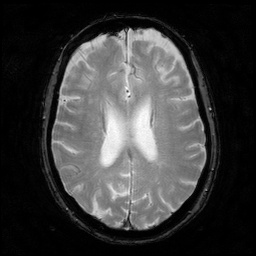

In [11]:
alex_1.get_sample_of_original_dataset(part="test")

Preprocessed Data Test Sample

Get sample of preprocessed dataset (test) with index: 0



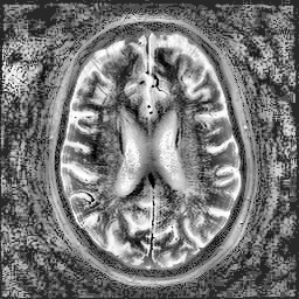

In [12]:
alex_1.get_sample_of_preprocessed_dataset(part="test")

In [ ]:
# # Load pre-trained InceptionV3 model and set as feature extractor
# model = tv.models.inception_v3(weights=True)
# model.aux_logits = False
# model.fc = torch.nn.Identity()  # Replace fully connected layer with identity for feature extraction

# # Move model to GPU if available and use DataParallel
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.device_count() > 1:
#     print(f'Using {torch.cuda.device_count()} GPUs!')
#     model = torch.nn.DataParallel(model)
# model = model.to(device)

Extract Features

In [14]:
# train_features, test_features = alex_1()

Save Features

In [13]:
# alex_1.save_extractor("./drive/Shareddrives/huda/Ayang/base_cpu")

In [ ]:
set(alex_1.train_labels)

{0, 1, 2, 3, 4, 5}

## Load Trained Model

In [7]:
alex_1 = AlzheptionExtractor.load_extractor("../../asset/AlzheptionExtractor.pkl", path_dataset_new="../../asset/dataset_jpg_brightness/")

alex_1.train_features.__len__(), alex_1.test_features.__len__()

(3532, 883)

In [8]:
alex_1.dataset

Dataset ImageFolder
    Number of datapoints: 4415
    Root location: ../../asset/dataset_jpg_brightness/

In [9]:
pd.DataFrame([alex_1.dataset.class_to_idx]).T

,0
AD,0
CN,1
EMCI,2
LMCI,3
MCI,4
SMC,5


In [10]:
alex_1.dataset[0]

(<PIL.Image.Image image mode=RGB size=256x256>, 0)

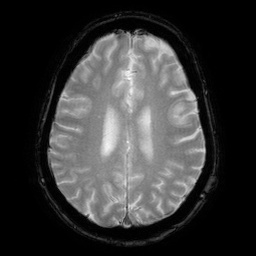

In [11]:
alex_1.dataset[0][0]

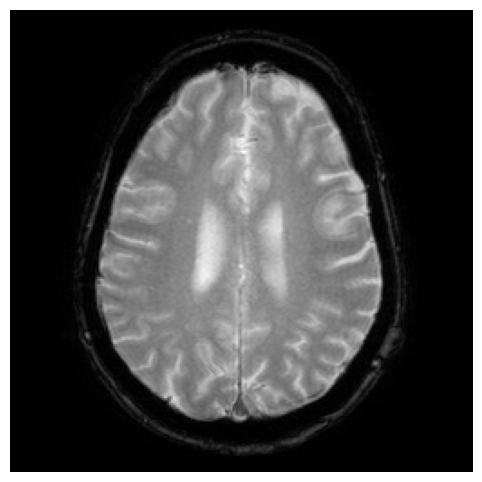

In [55]:
plt.figure(figsize=(13.5, 6))
plt.imshow(alex_1.dataset[0][0])
plt.axis('off')
plt.show()

In [12]:
alex_1.view_train_label_distribution()

,label,count
0,0,501
1,1,910
2,2,1159
3,3,632
4,4,76
5,5,254


In [13]:
alex_1.view_test_label_distribution()

,label,count
0,0,129
1,1,235
2,2,266
3,3,178
4,4,19
5,5,56


In [14]:
alex_1.balance_feature()

In [15]:
pca = PCA(n_components=456)
pca_train_features = pca.fit_transform(alex_1.train_features)
pca_test_features = pca.transform(alex_1.test_features)

pca_train_features.shape, alex_1.train_labels.__len__()

((456, 456), 456)

## KELM

In [16]:
# Cross Validation Param:
n_splits = 10
n_repeats = 10

In [17]:
# # Calculate using OSELM

# # Initialize OSELMLayer with specified parameters
# layer = OSELMLayer(num_neurons, 'mish')

# # Initialize OSELMModel with the OSELMLayer and other parameters
# model = OSELMModel(layer, prefetch_size=prefetch_size, batch_size=batch_size, verbose=0)

# # Perform cross-validation
# cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
# scores = cross_val_score(model, alex_1.train_features, alex_1.train_labels, cv=cv, scoring='accuracy', error_score='raise')

# # Print mean accuracy score
# print(np.mean(scores))

In [18]:
# Initialize KELM with a kernel function
# kernel = CombinedProductKernel([Kernel("rbf"), Kernel("laplacian")])
# kernel = CombinedSumKernel([Kernel("rbf"), Kernel("exponential")])
# kernel = Kernel("laplacian")
kernel = Kernel("rbf")

layer = KELMLayer(kernel, 'tanh')
kelm_model = KELMModel(layer)

In [124]:
# Cross-validation for KELM
scores = custom_cross_val_score(
    model=kelm_model, 
    X=pca_train_features, 
    y=alex_1.train_labels, 
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    scoring=accuracy_score, 
)
print("Cross-validated accuracy:", np.mean(scores))

Cross-validated accuracy: 0.3550821256038648


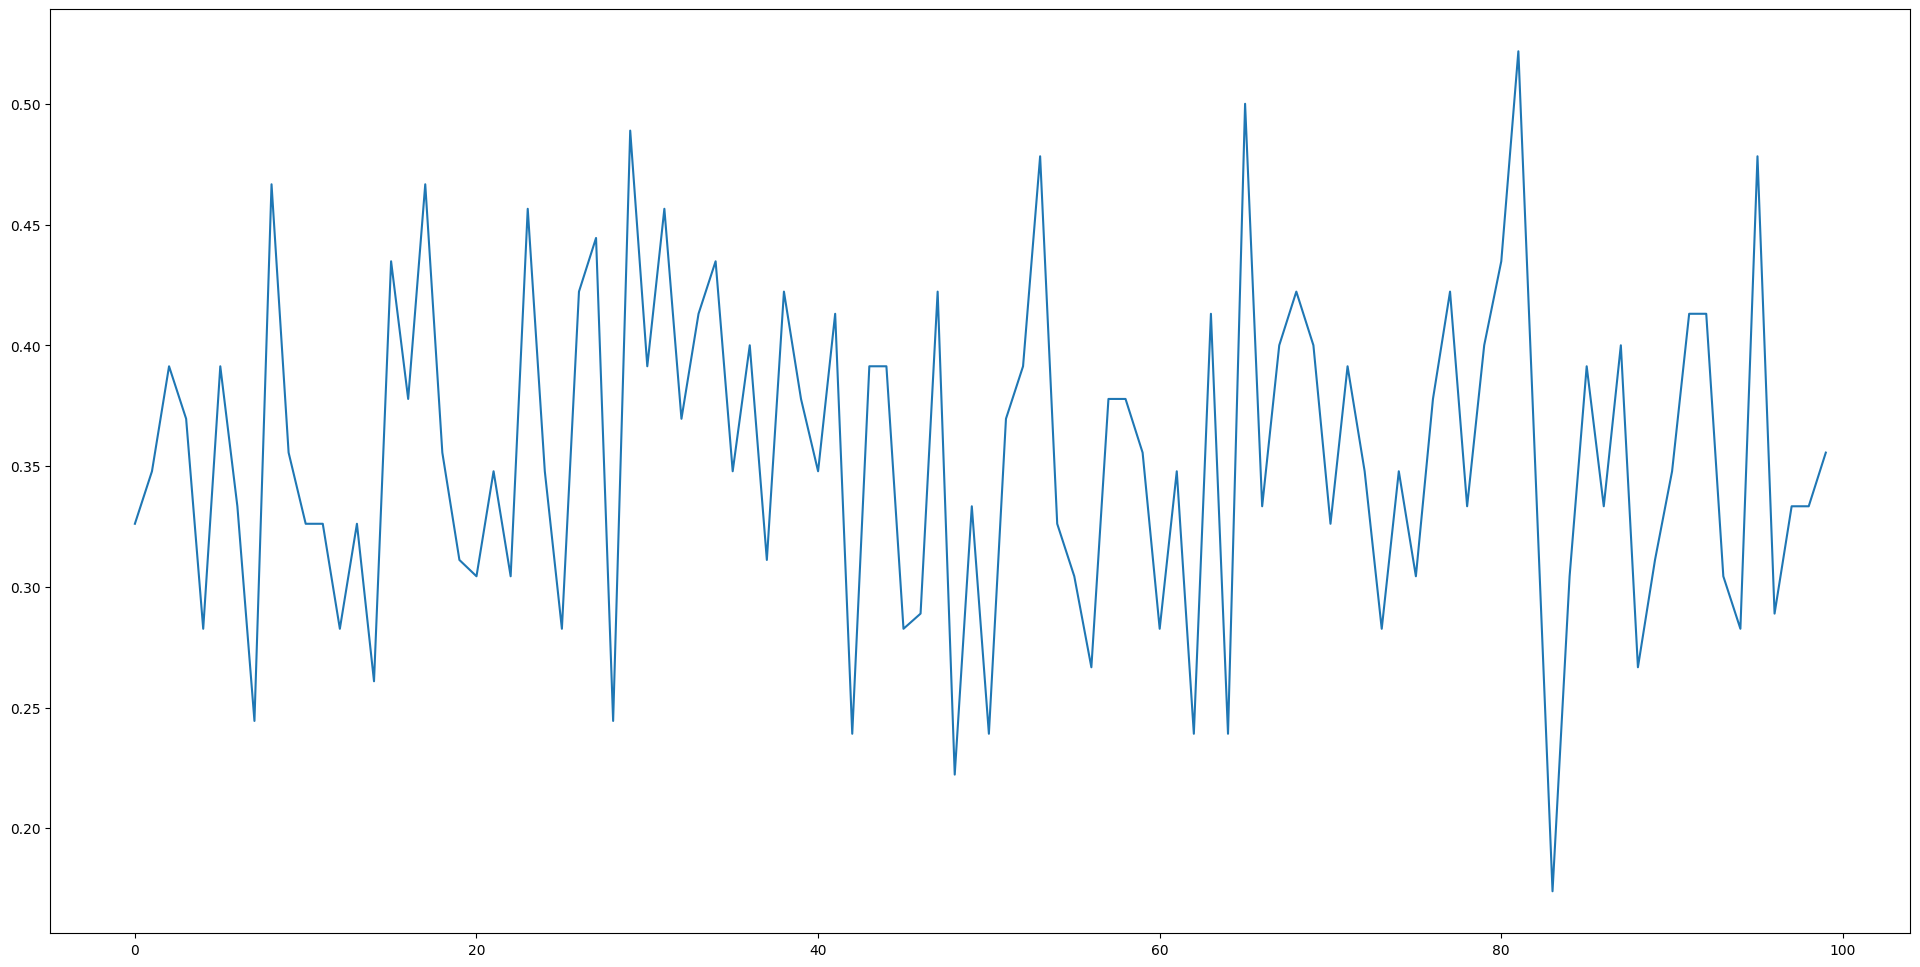

In [125]:
plt.figure(figsize=(24, 12))
plt.plot(scores)
plt.show()

In [126]:
# Train KELM on the extracted training features
kelm_model.fit(pca_train_features, alex_1.train_labels)

In [127]:
alex_1.train_features.shape, alex_1.test_features.shape

((456, 2048), (114, 2048))

In [128]:
# Evaluate the KELM model on the test set
predictions = kelm_model.predict(pca_train_features).numpy()
accuracy = accuracy_score(predictions, alex_1.train_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 1.0000


In [129]:
# Evaluate the KELM model on the test set
predictions = kelm_model.predict(pca_test_features).numpy()
accuracy = accuracy_score(predictions, alex_1.test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4035


In [130]:
alex_1.train_labels.shape, alex_1.test_labels.shape

((456,), (114,))

In [131]:
alex_1.test_labels.shape[0] / (alex_1.train_labels.shape[0] + alex_1.test_labels.shape[0])

0.2

In [132]:
# # Save and load the trained model
# kelm_model.save("Saved Models/KELM_Inception_Model.h5")
# # loaded_model = kelm_model.load("Saved Models/KELM_Inception_Model.h5")

## OSKELM

In [56]:
# Cross Validation Param:
n_splits = 10
n_repeats = 10

In [58]:
# Initialize KELM with a kernel function
# kernel = CombinedProductKernel([Kernel("rbf"), Kernel("laplacian")])
# kernel = CombinedSumKernel([Kernel("rbf"), Kernel("exponential")])
# kernel = Kernel("laplacian")
kernel = Kernel("rbf")

layer = KELMLayer(kernel, 'tanh')

In [61]:
pca_train_features = calculate_pairwise_distances(pca_train_features, kernel.ev).numpy()
pca_test_features = calculate_pairwise_distances(pca_test_features, kernel.ev).numpy()

pca_train_features.shape, pca_test_features.shape

((456, 456), (114, 114))

In [80]:
# Hyperparameter:
num_neurons = 1024
activation = "leaky_relu"
batch_size = 128
prefetch_size = 512

In [81]:
# Calculate using OSELM

# Initialize OSELMLayer with specified parameters
layer = OSELMLayer(num_neurons, activation)

# Initialize OSELMModel with the OSELMLayer and other parameters
model = OSELMModel(layer, prefetch_size=prefetch_size, batch_size=batch_size, verbose=0)

# Perform cross-validation
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
scores = cross_val_score(model, pca_train_features, alex_1.train_labels, cv=cv, scoring='accuracy', error_score='raise')

# Print mean accuracy score
print(np.mean(scores))

0.16013043478260866
